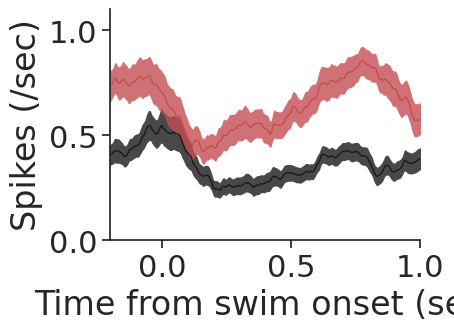

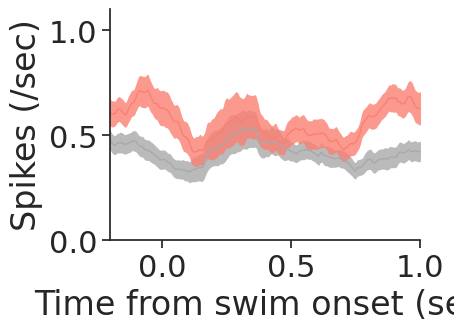

number of cells: 56
number of fish: 10


In [1]:
from utils import *

vol_file = '../Analysis/depreciated/analysis_sections_ablation_gain.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_len = t_pre+t_post
t_sig = 300 # time used for significance test after swim
non_spike_thres = 100

# dynamics_ablt(control_=False, c_str='_control')

control_=False
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')
k_ = gaussKernel(sigma=7)
gain_stat_len = 300
p_mat_before_ = []
p_mat_after_ = []
p_mat_short = []
pre_swim_act_before_ = []
swim_type_before_= []
pre_swim_act_after_ = []
swim_type_after_= []


for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    if not ablation_pair:
        continue
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    if ('control' in task_type)==control_:
        continue 
    ##### valid cell
    try:
        _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
        valid_cell = _['valid_cell']
    except:
        continue
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']     
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']

    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_ablt_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']

    if trial_valid_after.sum()<30:
        continue

    ### plot combined

    for n_cell in range(sub_swim.shape[0]):
        if not valid_cell[n_cell]:
            continue

        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        gain_stat = np.zeros(t_len)
        gain_stat[:] = np.nan
        if (task_period==2).sum()>0:
            for ntime in range(-t_pre, t_post):
                val, pval= ranksums(spk_list[(task_period==1) & trial_valid, t_pre+ntime], 
                                    spk_list[(task_period==2) & trial_valid, t_pre+ntime])
                gain_stat[ntime] = np.sign(-val) * pval
            v_s, gain_stat_short = ranksums(spk_list[(task_period==1) & trial_valid, t_pre:], 
                                    spk_list[(task_period==2) & trial_valid, t_pre:])
            gain_stat_short = np.sign(-v_s) * gain_stat_short
            p_mat_before_.append(gain_stat)
            tmp_ = [gain_stat_short]

        spk_list = spk_swim_after[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        gain_stat = np.zeros(gain_stat_len)
        if (task_period==2).sum()>0:
            for ntime in range(gain_stat_len):
                val, pval= ranksums(spk_list[(task_period_after==1) & trial_valid_after, t_pre+ntime], 
                                    spk_list[(task_period_after==2) & trial_valid_after, t_pre+ntime])
                gain_stat[ntime] = np.sign(val) * pval
            v_s, gain_stat_short = ranksums(spk_list[(task_period_after==1) & trial_valid_after, t_pre:].mean(axis=-1), 
                                    spk_list[(task_period_after==2) & trial_valid_after, t_pre:].mean(axis=-1))
            gain_stat_short = np.sign(-v_s) * gain_stat_short
            p_mat_after_.append(gain_stat)
            tmp_.append(gain_stat_short)       
            p_mat_short.append(tmp_)


sig_thres = 10
p_mat = np.array(p_mat_before_)
sig_mat = np.abs(p_mat)<0.05
sel_ind = sig_mat.sum(axis=-1)>sig_thres
p_mat = np.array(p_mat_after_)
sig_mat = np.abs(p_mat)<0.05
sel_ind_ = sig_mat.sum(axis=-1)>sig_thres

k_ = gaussKernel(sigma=1)
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')
gain_list = []
cell_before = []
cell_after = []
diff_act = []
fish_list = []
### spike plots
for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    if not ablation_pair:
        continue
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    if ('control' in task_type)==control_:
        continue     
    try:
        _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
        valid_cell = _['valid_cell']
    except:
        continue
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_ablt_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']

    if trial_valid_after.sum()<30:
        continue
    for n_cell in range(sub_swim.shape[0]): 
        if not valid_cell[n_cell]:
            continue
        fish_list.append(folder+fish[:5])
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)

        ave_ = spk_list[trial_valid, :]*300
        ave1 = spk_list[(task_period==1) & trial_valid, :]*300
        ave2 = spk_list[(task_period==2) & trial_valid, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_before.append([np.nanmean(ave_, axis=0), np.nanmean(ave1, axis=0), np.nanmean(ave2, axis=0)])
        pre_swim_act_before_.append(spk_list[:, :t_pre-30].mean(axis=1))
        swim_type_before_.append(task_period)
        diff_act.append((np.nanmean(ave2, axis=0)-np.nanmean(ave1, axis=0)).sum())
        spk_list = spk_swim_after[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        ave_ = spk_list[trial_valid_after, :]*300
        ave1 = spk_list[(task_period_after==1) & trial_valid_after, :]*300
        ave2 = spk_list[(task_period_after==2) & trial_valid_after, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_after.append([np.nanmean(ave_, axis=0), np.nanmean(ave1, axis=0), np.nanmean(ave2, axis=0)])
        pre_swim_act_after_.append(spk_list[:, :t_pre-30].mean(axis=1))
        swim_type_after_.append(task_period_after)

sel_all = sel_ind | sel_ind_
fish_list = np.array(fish_list)
fishid = np.unique(fish_list)
plt.figure(figsize=(4, 3))
tmp_ind = sel_all & (np.array(diff_act)>0)
mean_ = np.mean(np.array(cell_before)[tmp_ind, 1], axis=0)
std_ = sem(np.array(cell_before)[tmp_ind, 1], axis=0)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='k')
mean_ = np.mean(np.array(cell_before)[tmp_ind, 2], axis=0)
std_ = sem(np.array(cell_before)[tmp_ind, 2], axis=0)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='r')
sns.despine()
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time from swim onset (sec)')
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.1])
plt.show()

plt.figure(figsize=(4, 3))
mean_ = np.mean(np.array(cell_after)[tmp_ind, 1], axis=0)
std_ = sem(np.array(cell_after)[tmp_ind, 1], axis=0)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='darkgray')
mean_ = np.mean(np.array(cell_after)[tmp_ind, 2], axis=0)
std_ = sem(np.array(cell_after)[tmp_ind, 2], axis=0)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='salmon')
sns.despine()
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time from swim onset (sec)')
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.1])
plt.show()

print(f'number of cells: {sum(tmp_ind)}')
print(f'number of fish: {np.unique(np.array(fish_list)[tmp_ind]).shape[0]}')

In [77]:
pre_swim_act = pre_swim_act_after_
swim_type = swim_type_after_

# pre_swim_act = pre_swim_act_before_
# swim_type = swim_type_before_

lh_pre = []
hl_pre = []

for n_cell in np.where(tmp_ind)[0]:
    act_ = pre_swim_act[n_cell]
    n_swims = swim_type[n_cell]
    epoch_start = np.r_[0, np.diff(n_swims)]
    epoch_start_lh = np.where(epoch_start==-1)[0]
    epoch_start_lh = epoch_start_lh[:-1]
    lh_trial = np.zeros((len(epoch_start_lh), 10))
    for n in range(10):
        lh_trial[:, n-3] = act_[epoch_start_lh+n-3]
    
    epoch_start_hl = np.where(epoch_start==1)[0]
    epoch_start_hl = epoch_start_hl[:-1]
    hl_trial = np.zeros((len(epoch_start_hl), 10))
    for n in range(10):
        hl_trial[:, n-3] = act_[epoch_start_hl+n-3]

    # print(n_cell)
    lh_pre.append(lh_trial.mean(axis=0))
    hl_pre.append(hl_trial.mean(axis=0))
lh_pre = np.array(lh_pre)
hl_pre = np.array(hl_pre)

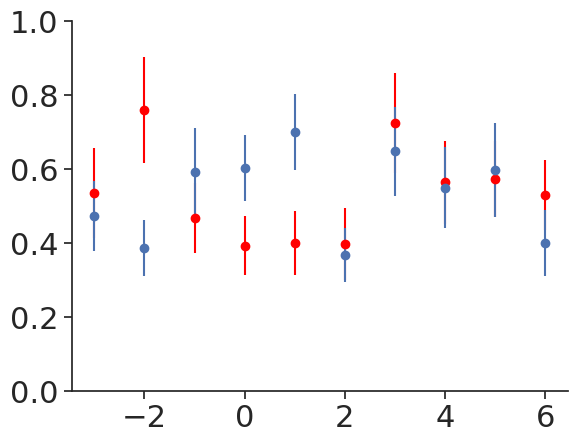

In [78]:
ave_ = lh_pre.mean(axis=0) *300
std_ = lh_pre.std(axis=0)/7 *300
# order_ = np.argsort(ave_)
order_ = np.arange(10)

plt.errorbar(np.arange(-3, 7), ave_[order_], std_[order_], color='red', ls='none', marker='o')

ave_ = hl_pre.mean(axis=0) *300
std_ = hl_pre.std(axis=0)/7 *300
# order_ = np.argsort(-ave_)
order_ = np.arange(10)

plt.errorbar(np.arange(-3, 7), ave_[order_], std_[order_], color='b', ls='none', marker='o')

sns.despine()
plt.ylim([0, 1.0])
plt.savefig('pre_swim_rate.pdf')

In [36]:
from glob import glob

In [69]:
selected_fish = np.unique(np.array(fish_list)[tmp_ind])

swim_bout_len = []
for n_fish in selected_fish:
    folder = n_fish[:8]
    fish = n_fish[8:]
    file_ = glob(f'../Analysis/swim_power/{folder}_{fish}*after_swim_dat.npz')[0]
    _ = np.load(file_, allow_pickle=True)
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_bout_len.append(np.diff(swim_starts).mean()/300)
swim_bout_len = np.array(swim_bout_len)

In [75]:
np.mean(swim_bout_len[swim_bout_len<5])*10

25.062704072167588

In [76]:
np.std(swim_bout_len[swim_bout_len<5])*10

12.065070909488893

In [72]:
swim_bout_len

array([0.76379696, 2.86684848, 4.1367619 , 1.56502463, 2.16009434,
       4.33254237, 5.40973856, 1.34787234, 5.6882    , 2.87722222])